# Airbnb Listings in Seattle
Author: Matthew Huh

## What is Airbnb
To put it in their own words, "Airbnb is built around the idea that everyone should be able to take the perfect trip, including where they stay, what they do, and who they meet. To that end, we empower millions of people around the world to use their spaces, passions, and talents to become entrepreneurs."

It is a platform that allows people to host their abodes as temporary living quarters for tourism, finding a place away from home, or short-term housing. In certain ways, the platform offers a number of similarities to hotels, or renting apartments, but it comes with its own advantages and disadvantages.

## About the Data
Airbnb regularly uploads datasets on their site, allowing individuals, or organizations to play around with the listings that they have disclosed. For this project, I have chosen to take a closer look at a city quite familiar to me, Seattle, WA, home to over 700k people and a thriving tech and tourism hub in the Pacific Northwest.

## Research Question

## Packages

In [1]:
# Necessary imports
import os
import time
import timeit
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Modelling packages
from sklearn import ensemble
from sklearn.feature_selection import chi2, f_classif, SelectKBest 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import adjusted_rand_score, classification_report, confusion_matrix, silhouette_score
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import normalize

# Plotly packages
import cufflinks as cf
import ipywidgets as widgets
import plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly import tools
from scipy import special
py.offline.init_notebook_mode(connected=True)

In [2]:
# Import the data
listings = pd.read_csv('listings.csv')
neighborhoods = pd.read_csv('neighbourhoods.csv')
neighborhood_map = pd.read_json('neighbourhoods.geojson')

# Remove the 'id' column from the dataframe
listings.drop(['id', 'host_id'], axis=1, inplace=True)

In [3]:
# Preview the data for listings
listings.head()

,name,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,"Casa Madrona - Urban Oasis, 1 block from the P...",Megan,Central Area,Madrona,47.610819,-122.290816,Entire home/apt,296,4,20,2018-09-18,0.16,3,345
1,Sunrise in Seattle Master Suite,Jess & Joey,Other neighborhoods,Roosevelt,47.687801,-122.313427,Private room,82,2,63,2018-10-06,0.96,5,365
2,"Cozy Studio, min. to downtown -WiFi",Maddy,Delridge,South Delridge,47.523980,-122.359891,Entire home/apt,48,3,461,2018-11-02,4.37,1,24
3,"Fab, private seattle urban cottage!",Joyce,Other neighborhoods,Wallingford,47.654109,-122.337605,Entire home/apt,90,2,134,2018-10-21,1.18,3,287
4,Glorious sun room w/ memory foambed,Angielena,Other neighborhoods,Georgetown,47.550620,-122.320135,Private room,65,2,130,2018-09-09,1.29,5,336


In [4]:
# Print the size of the dataframe
print('Size of the dataframe: {} listings x {} features'.format(listings.shape[0],listings.shape[1]))

Size of the dataframe: 8740 listings x 14 features


In [5]:
# Check for any missing values
print('Missing values: \n', listings.isna().sum())

Missing values: 
 name                                 0
host_name                            0
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       1048
reviews_per_month                 1049
calculated_host_listings_count       0
availability_365                     0
dtype: int64


In [6]:
# View descriptive statistics
listings.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,8740.000000,8740.000000,8740.000000,8740.000000,8740.000000,7691.000000,8740.000000,8740.000000
mean,47.626403,-122.333693,152.228375,3.691419,42.772769,2.462089,22.570252,138.483295
std,0.045696,0.031548,141.676868,13.235492,63.760075,2.427051,62.737811,130.909168
min,47.496037,-122.419637,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,47.606366,-122.354144,80.000000,1.000000,3.000000,0.565000,1.000000,14.000000
50%,47.621423,-122.332098,119.000000,2.000000,17.000000,1.690000,1.000000,89.000000
75%,47.661255,-122.312031,189.000000,2.000000,55.000000,3.820000,5.000000,263.000000
max,47.736128,-122.234026,5400.000000,400.000000,717.000000,46.410000,311.000000,365.000000


In [7]:
# View room types on Airbnb

# Set the size of the chart
plt.rcParams['figure.figsize'] = [5,5]

# Import the data for the pie chart
trace = go.Pie(labels=listings['room_type'].value_counts().index, values = listings['room_type'].value_counts())

# Create the layout
layout = go.Layout(
    title = 'Room Types on Airbnb',
    height = 600,
    width = 800,
    autosize = False
)

# Construct the chart
fig = go.Figure(data = [trace], layout = layout)
py.offline.iplot(fig, filename ='cufflinks/simple')

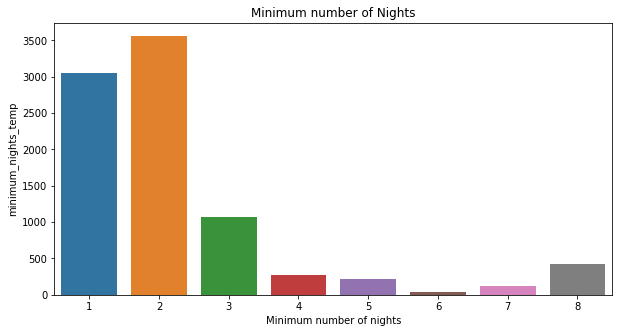

In [8]:
# Plot the minimum number of nights required for units
plt.rcParams['figure.figsize'] = [10,5]

listings['minimum_nights_temp'] = np.where(listings['minimum_nights'] > 7, 8, listings['minimum_nights'])

plt.title('Minimum number of Nights')
plt.xlabel('Minimum number of nights')
sns.barplot(x = listings['minimum_nights_temp'].value_counts().index,
            y = listings['minimum_nights_temp'].value_counts())

listings.drop('minimum_nights_temp', axis=1)
print()

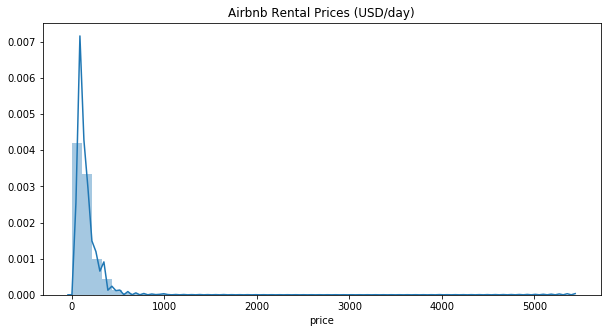

In [9]:
# View all prices
plt.title('Airbnb Rental Prices (USD/day)')
sns.distplot(listings['price'])

So, that's a nice visual, eh? All that we can really see is that most listings are below 1000 USD / day, and that at least one listing is a little over 5000 USD. Let's take a look at the prices again, and focus on what 99% of us will be looking at using the outlier rule (Q3 + 1.5 (Q3 - Q1))

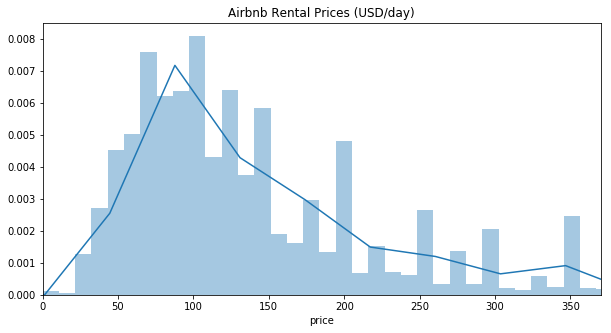

In [10]:
# Examine by removing outliers
plt.xlim(0,370)
plt.title('Airbnb Rental Prices (USD/day)')
sns.distplot(listings['price'], bins=500)

In [11]:
# View most expensive listings in Seattle
listings.sort_values(by = 'price', ascending=False).head(10)

,name,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,minimum_nights_temp
7845,Light &Airy home--convenient Seattle location,Deanna,Central Area,Harrison/Denny-Blaine,47.621206,-122.293840,Entire home/apt,5400,7,0,NaN,NaN,1,143,7
8107,We are true 12's!,Chris,Queen Anne,West Queen Anne,47.630456,-122.367444,Entire home/apt,4000,1,0,NaN,NaN,1,0,1
1041,Neat & Roomy Photography Studio,Steve,Central Area,Minor,47.602292,-122.308681,Entire home/apt,3999,29,58,2016-09-21,1.29,5,0,8
5405,Spacious Family-Friendly Tri-Plex with Views i...,Kimberly,Queen Anne,West Queen Anne,47.630824,-122.368964,Entire home/apt,1650,2,3,2018-08-07,0.22,5,222,2
3908,Seattle Executive Home for Large Gatherings,Andrew,Seward Park,Seward Park,47.547348,-122.266204,Entire home/apt,1395,7,2,2018-08-19,0.10,1,358,7
6963,Summer Apart (girls only),Happy,University District,University District,47.663574,-122.315006,Private room,1250,7,0,NaN,NaN,1,365,7
3892,Beautiful French Style Home with Panoramic Views.,Amy,Queen Anne,Lower Queen Anne,47.629652,-122.360114,Entire home/apt,1200,4,2,2017-08-06,0.10,1,8,4
6982,LARGE HOUSE ON LAKE WASHINGTON WITH HOT TUB!!!!,Jason,Central Area,Leschi,47.591348,-122.287627,Entire home/apt,1129,30,9,2018-08-09,1.57,12,365,8
4485,Family luxury-steps to Columbia City & light r...,Joel And Amanda,Rainier Valley,Columbia City,47.558111,-122.289506,Entire home/apt,1079,2,20,2018-10-07,1.15,1,362,2
904,Private Townhome 2 bedroom 1.5 bath,Natalie,Rainier Valley,Mount Baker,47.564861,-122.285446,Entire home/apt,1000,2,23,2018-06-29,0.48,1,0,2


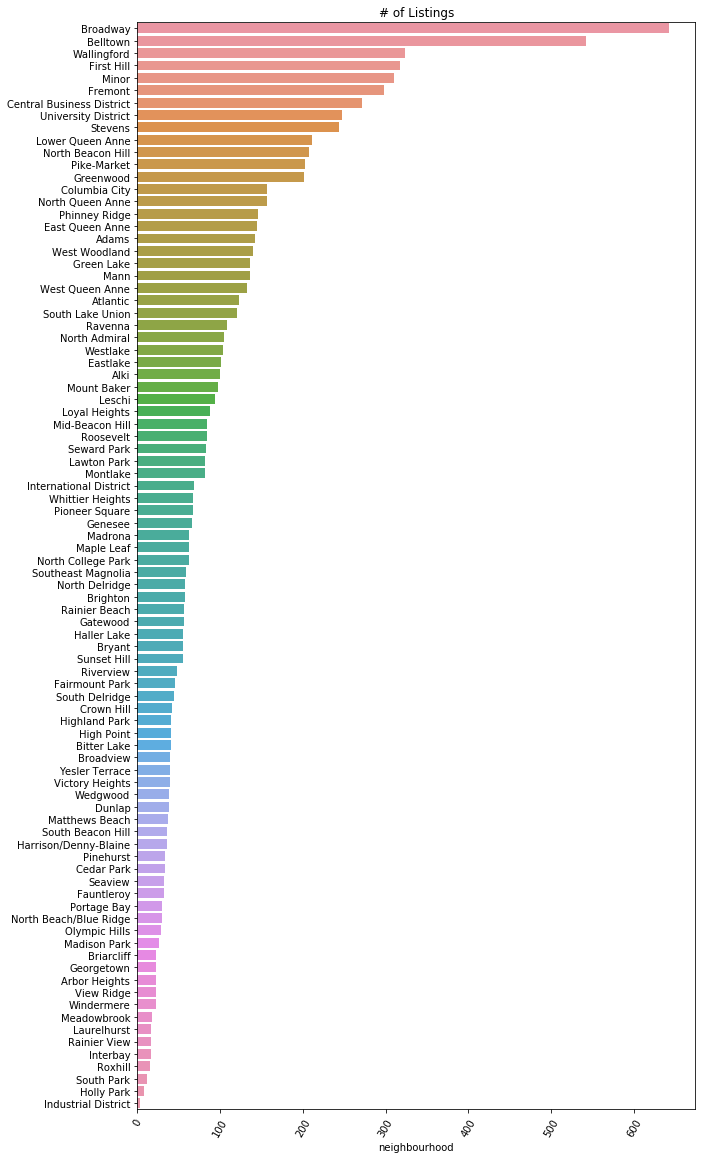

In [12]:
# View # of listings by neighbourhood
plt.rcParams['figure.figsize'] = [10,20]

plt.title('# of Listings')
plt.xticks(rotation=60)
sns.barplot(x = listings['neighbourhood'].value_counts(),
            y = listings['neighbourhood'].value_counts().index)

In [13]:
# Create new dataframe for the statistics on each neighbourhood
neighbourhood_averages = listings.groupby(['neighbourhood']).mean()
neighbourhood_averages

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,minimum_nights_temp
neighbourhood,,,,,,,,,
Adams,47.671825,-122.386322,138.147887,4.281690,54.521127,2.728203,2.669014,142.795775,2.542254
Alki,47.575216,-122.406858,180.870000,2.670000,40.900000,2.930353,3.060000,167.050000,2.180000
Arbor Heights,47.510825,-122.379924,131.173913,2.086957,56.130435,3.297143,1.260870,110.260870,2.086957
Atlantic,47.595275,-122.304397,117.609756,2.390244,56.317073,3.162609,3.243902,80.813008,2.056911
Belltown,47.615074,-122.346078,195.643911,4.326568,40.566421,2.599138,72.691882,142.612546,2.232472
Bitter Lake,47.720124,-122.351726,88.585366,6.634146,26.463415,2.067500,1.609756,154.268293,2.243902
Briarcliff,47.643675,-122.405051,212.478261,2.608696,23.478261,1.286000,3.652174,139.347826,2.608696
Brighton,47.539739,-122.277059,103.245614,1.491228,37.473684,2.596078,8.561404,108.964912,1.491228
Broadview,47.717846,-122.360142,110.450000,2.275000,44.975000,2.404571,1.225000,195.825000,2.275000


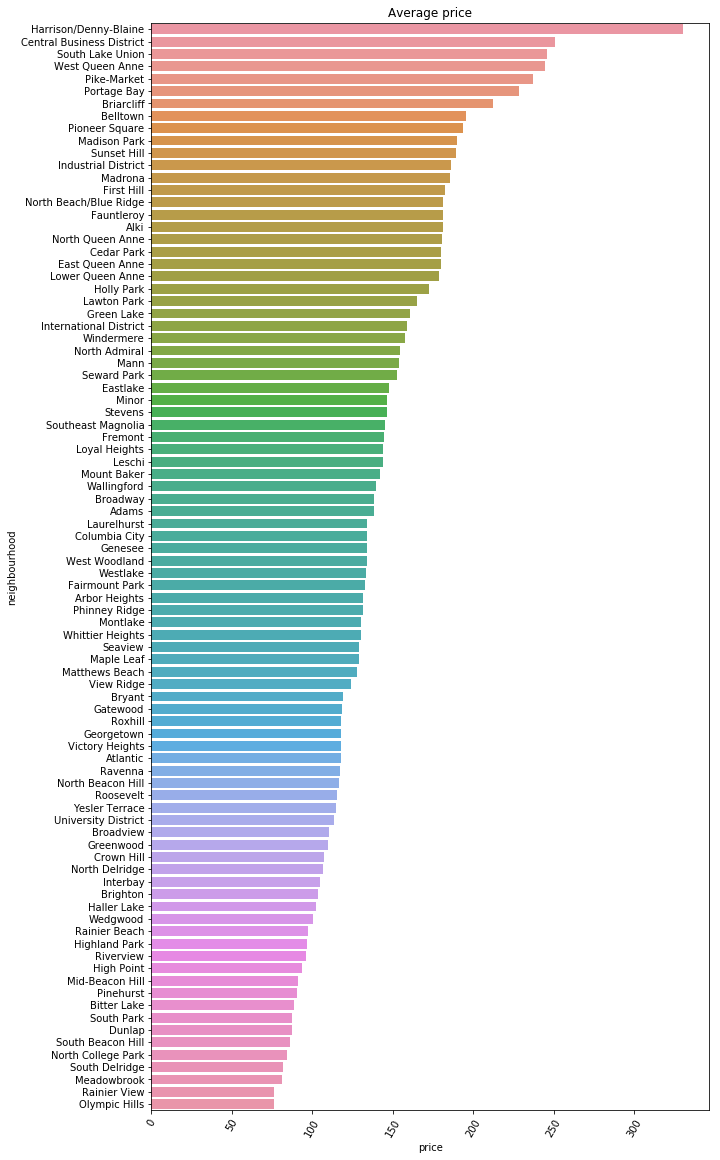

In [14]:
# View # of listings by neighbourhood
plt.rcParams['figure.figsize'] = [10,20]

neighbourhood_averages.sort_values('price', ascending=False, inplace=True)
plt.title('Average price')
plt.xticks(rotation=60)
sns.barplot(x = neighbourhood_averages['price'],
            y = neighbourhood_averages.index)

In [15]:
# Mapbox API credentials
mapbox_access_token = 'pk.eyJ1IjoibWh1aDIyIiwiYSI6IkpGdEhkXzgifQ.Af4NVoaKw7lvlqVyak8Ydw'

# Import the data for the map
data = go.Data([

    go.Scattermapbox(
        lat = neighbourhood_averages['latitude'],
        lon = neighbourhood_averages['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=9
        ),
        text = neighbourhood_averages.price,
    )
])

# Format the layout of the map
layout = go.Layout(
    title = 'Airbnb Units in Seattle',
    height=600,
    autosize=True,
    hovermode='closest',
    mapbox=dict(
        layers=[
            dict(
                sourcetype = 'geojson',
                source = 'neighbourhoods.geojson',
                type = 'fill',
                color = 'rgba(40,0,113,0.8)'
            )
        ],
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=47.6062,
            lon=-122.3321
        ),
        pitch=0,
        zoom=9.5,
        style='light',
    ),
)

fig = dict(data=data, layout=layout)
py.offline.iplot(fig, filename='county-level-choropleths-python')

C:\Users\mhuh22\Anaconda3\lib\site-packages\plotly\graph_objs\_deprecations.py:39: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




In [16]:
get_ipython().run_cell_magic('html', '', '<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/code_toggle.js"></script>')

# Source
http://insideairbnb.com/get-the-data.html